In [1]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
import math
import sys
import traceback
from csv import excel
from collections import Counter
from scipy import stats

path='../save_outputs/vol-vfd'
nshow=6
step=1
padding=nshow

In [2]:
# data related methods
def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1000 and i < len(suffixes)-1:
        nbytes /= 1000.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

def check_empty(df,p=True):
    nan_df = df[df.isna().any(axis=1)].copy()
    if not nan_df.empty:
        if p:
            print(f"NaN rows: {nan_df}") # check any nan
        return list(nan_df.index)
    
    null_df = df[df.isnull().any(axis=1)].copy()
    if not null_df.empty:
        if p:
            print(f"NULL rows: {null_df}") # check any null
        return list(null_df.index)
    
def print_list_diff(list1, list2):
    if list1 == list2:
        print("same lists")
    else:
        print("different lists\nindex:\t[list1]\t[list2]")
        for index, (first, second) in enumerate(zip(list1, list2)):
            if first != second:
                # print(index, first, second)
                print(f"{index}:\t{first}]\t[{second}]")

def df_to_csv(df,file_name,suffix=''):
    # df.hash_id=df.hash_id.astype('category').cat.codes
    # out_csv=file_name.replace('prov-vfd-','')
    out_csv=file_name.replace('.csv',f'{suffix}.csv')
    df.to_csv(out_csv,index=False)
    
def read_data(filename, dset=''):
    if '.parquet' in filename:
        df = pd.read_parquet(filename,engine='pyarrow')
    if'.csv' in filename:
        df = pd.read_csv(filename,index_col=False)
    
    if len(dset) > 0:
        df = df[df['dset_name'] == dset]
        
    return df

def get_min_max_loc(G):
    ret_dict = {}
    attr_dict = nx.get_node_attributes(G,'pos')
    min_x = min(attr_dict.values())[0]
    max_x = max(attr_dict.values())[0]
    for k,v in attr_dict.items():
        if v[0] == min_x:
            ret_dict['min'] = { k:v }
        if v[0] == max_x:
            ret_dict['max'] = { k:v }
    return ret_dict

In [3]:
# networkx related methods
# color names : https://www.w3schools.com/colors/colors_names.asp
COLOR_MAP = {"task": "FireBrick", # read
            "vol": "Salmon", #orange
            "contact_map": "Tomato", 
            "point_cloud": "OrangeRed", 
            "addr": "SkyBlue", # blue
            # "logical_addr": "SkyBlue", #light blue
            # "logical_addr_vfd": "PowderBlue", # slightly different light lue
            "file": "RoyalBlue", # darker blue
            "none": "grey",
            }

def rm_name_tags(name, tags):
    for t in tags:
        name = str(name).replace(f"{t}-","")
        name = str(name).replace("vol-","")
        name = str(name).replace("contact_map","cm")
        name = str(name).replace("point_cloud","pc")
    return name

def draw_graph(G,color_map=COLOR_MAP, rm_tags=['']):
    pos=nx.get_node_attributes(G,'pos')
    names = nx.get_node_attributes(G,'name')

    node_colors = [] 
    # set node colors
    for name in names.values():
        _n = rm_name_tags(name, rm_tags)
        node_colors.append(color_map[_n])
        
    # set node labels
    labels = {}
    for node in names.keys():
        _n = rm_name_tags(node, rm_tags)
        labels[node] = _n

    plt.figure(figsize=(25, 10)) #figsize=(40, 10)
    # plt.figure(figsize=(50, 50))
    
    bbox = dict(alpha=0.6, fc="black", ec="white", boxstyle="square", color='white') #fc="red", , lw=3
        
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, labels= labels, bbox=bbox, horizontalalignment='left', font_color='white')
    
    # for edge in G.edges(data='access_cnt'):
    #     nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=edge[2], )
    nx.draw_networkx_edges(G, pos=pos, edgelist=G.edges)
    
    plt.axis("off")
    plt.margins(x=0.1)
    
    out_tag = '-'.join(rm_tags)
    plt.savefig(f"{path}/networkx-sampled-{out_tag}.png")
    
    plt.show()
    

def add_attr_dic_edges(G, edges, io_idx, ops, asize):
    attr_dict = {}
    edge_cnt = {}

    # print(edges)

    for i, e in enumerate(edges):
        if e in edge_cnt.keys():
            if edge_cnt[e]['io_idx'] != io_idx[i]:
                edge_cnt[e]['cnt'] +=1
        else:
            edge_cnt[e] = {}
            edge_cnt[e]['cnt'] = 1
            edge_cnt[e]['io_idx'] = io_idx[i]
    
    # print(edge_cnt)
    pos = nx.get_node_attributes(G,'pos')

    for i, e in enumerate(edges):
        try:
            attr_dict[e] = {'access_cnt': edge_cnt[e]['cnt'], 'access_size': asize[i], 'operation': ops[i]} # 'time': times[i]
            # # update node x-axis
            # node = e[1]
            # node_y = pos[node][1]
            # G.add_node(node,pos=(times[i],node_y))

        except:
            print(f"i={i} edge={e}")
            # print(asize)
            # print(ops)
            traceback.print_exc()
            # break
    # print(pos)

    G.add_edges_from(edges)
    nx.set_edge_attributes(G,attr_dict)

def add_nodes_edges(G, l1, l2, ops, io_idx, times=[], acc_s=[], x_pos=0, tags=['','']):
    #column1, column2, io_idx, access_size
    _x = x_pos
    _y = -1

    count = 0
    prev_node = -1
    prev_time = -1
    l1t = []
    if len(l1) == 1:
        l1t.append(f"{tags[0]}-{l1[0]}")
    else:
        for i,node in enumerate(l1):
            if node == prev_node:
                tmp = f"{tags[0]}-{node}:({prev_time})" #times[0][i]
            else:
                prev_time = times[0][i]
                tmp = f"{tags[0]}-{node}:({prev_time})" #times[0][i]
            l1t.append(tmp)
            prev_node = node
        
    l2t = []
    if len(l2) == 1:
        l2t.append(f"{tags[1]}-{l2[0]}")
    else:
        for i,node in enumerate(l2):
            if node == prev_node:
                tmp = f"{tags[1]}-{node}:({prev_time})" 
            else:
                prev_time = times[1][i]
                tmp = f"{tags[1]}-{node}:({prev_time})" 
            l2t.append(tmp)
            prev_node = node
    
    for i, l in enumerate([l1t, l2t]):
        _addr_pos = []
        if 'addr' in tags[i]:
            if i == 0:
                org_vals = l1
            else:
                org_vals = l2 
            _addr_pos = stats.rankdata(org_vals,method='dense')
            _addr_pos = [x*step for x in _addr_pos]
    
        for j,n in enumerate(l):
            
            if(G.has_node(n) == False):
                _y+=1

                if len(_addr_pos) > 0:
                    G.add_node(n,pos=(times[i][j],_addr_pos[j]),name=tags[i])
                else:
                    if len(l) == 1:
                        G.add_node(n, pos=(_x,_y), name=tags[i])
                    else:
                        G.add_node(n, pos=(times[i][j],_y), name=tags[i])
        _x+=step
        
    if len(l1t) == 1:
        l1t = l1t * len(l2t)
    if len(l2t) == 1:
        l2t = l2t * len(l1t)
    if len(acc_s) == 0:
        acc_s = [1] * len(l1t)
    
    add_attr_dic_edges(G, list(zip(l1t, l2t)), io_idx, ops, acc_s)

    # update node location if it is task/file at the end
    if  tags[-1] == 'task' or tags[-1] == 'file':
        try:
            node = l2t[0] #f"{l2t[0]}-{times[0]}"
            node_pos = nx.get_node_attributes(G,'pos')[node]
            # print(f"lastnode - {node} : {node_pos}")
            new_x = max(nx.get_node_attributes(G,'pos').values())[0] + padding
            old_y = node_pos[1]
            G.add_node(node,pos=(new_x,old_y))
        except:
            print(node)

Index(['data_label_vol', 'object_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'io_idx_vol', 'logical_addr_map', 'data_label_vfd', 'object_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'logical_addr_vfd', 'file_name',
       'time(us)_vfd', 'operation_vfd', 'io_idx_vfd'],
      dtype='object')
[14, 15, 16, 17, 18, 19, 20, 26, 27, 28, 29, 30, 21, 22, 23, 24, 25, 31]
{'min': {'task-sim': (0, 0)}, 'max': {'file-residue.h5': (39, 0)}}


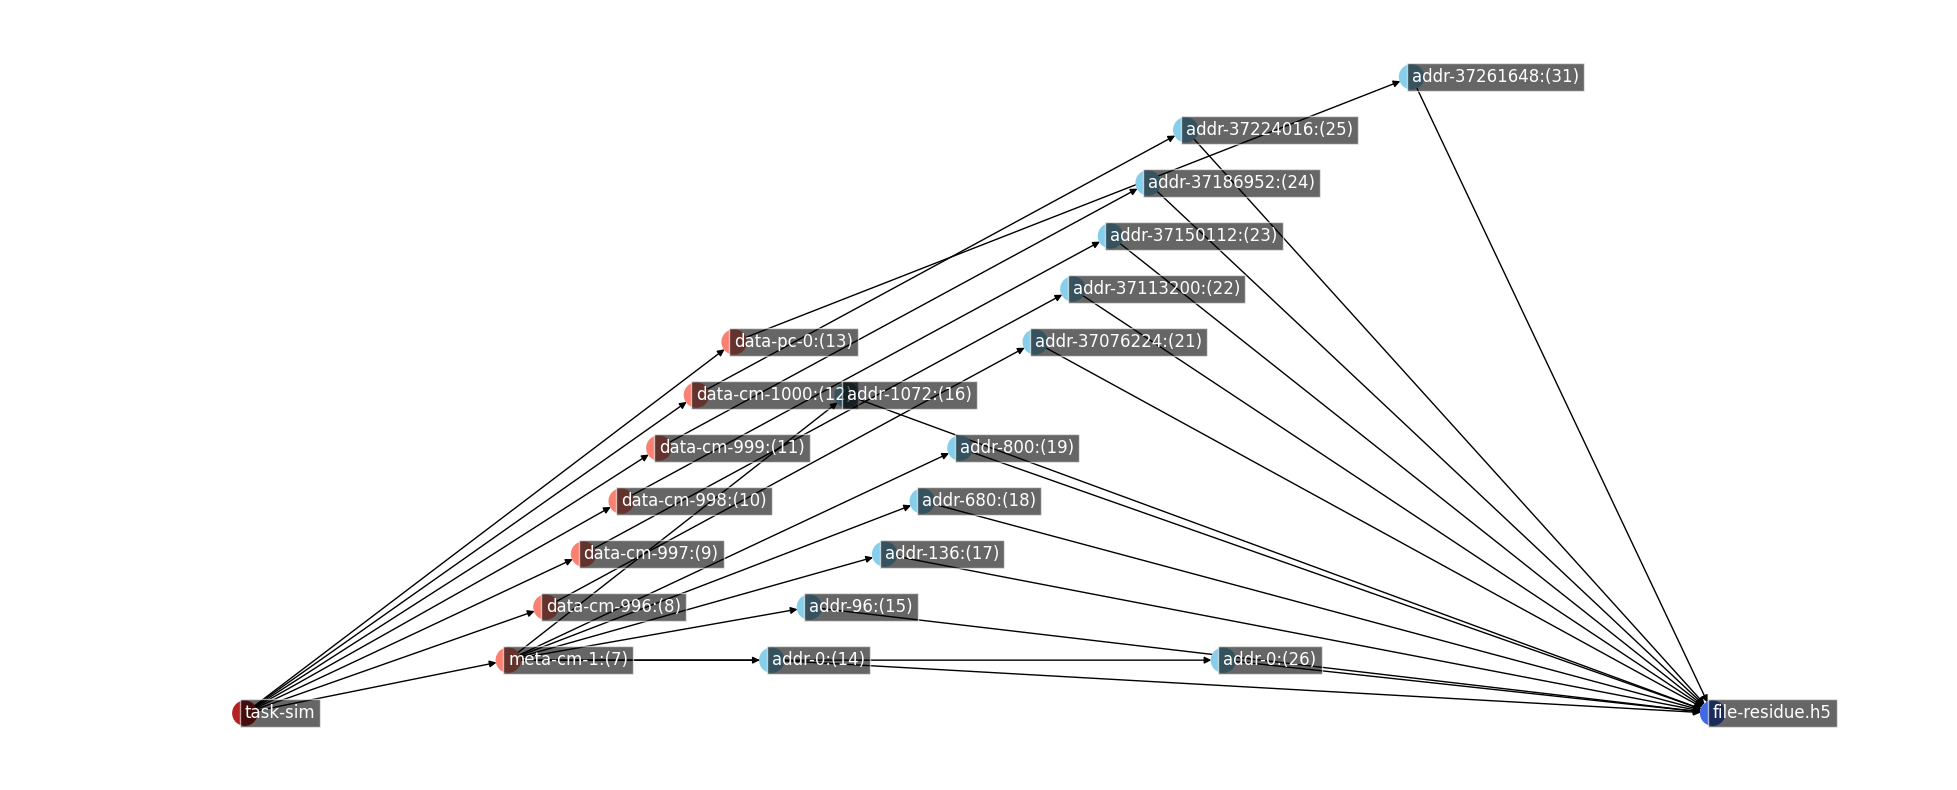

In [4]:
fsim='../save_outputs/vol-vfd/prov-vfd-sim-merged.csv'
df_sim_merged = read_data(fsim)
print(df_sim_merged.columns)

df_sim = pd.concat([df_sim_merged.head(nshow*2),df_sim_merged.tail(nshow)])
# df_sim = df_sim_merged

# convert time to rank
vol_time = stats.rankdata(df_sim['time(us)_vol'],method='dense') #df_sim_merged['time(us)_vol'].min()
vol_time = [x+padding for x in vol_time]
# vol_time = [x*step for x in vol_time]
max_left = max(vol_time)
vfd_time = stats.rankdata(df_sim['time(us)_vfd'],method='dense')
vfd_time = [x + (max_left) for x in vfd_time]
# vfd_time = [x*step for x in vfd_time]
print(vfd_time)
min_right = min(vfd_time)
# print(f"max_left = {max_left} min_right = {min_right}")

G_SIM = nx.DiGraph()

x_pos = 0
add_nodes_edges(G_SIM, ['sim'], list(df_sim['data_label_vol']), 
                    list(df_sim['operation_vol']), 
                    list(df_sim['io_idx_vol']),
                    [[x_pos],vol_time], 
                    acc_s=list(df_sim['access_size_vol']),
                    x_pos=x_pos, tags=['task','sim-vol'])

x_pos = max(nx.get_node_attributes(G_SIM,'pos').values())[0] + 1
# print(get_min_max_loc(G_SIM))
add_nodes_edges(G_SIM, list(df_sim['data_label_vol']), list(df_sim['logical_addr_vfd']), 
                    list(df_sim['operation_vol']), 
                    list(df_sim['io_idx_vol']),
                    [vol_time,vfd_time], 
                    acc_s=list(df_sim['access_size_vfd']),
                    x_pos=x_pos, tags=['sim-vol','sim-addr'])


x_pos = max(nx.get_node_attributes(G_SIM,'pos').values())[0] + 1
x_time = max(vol_time) +1
# print(get_min_max_loc(G_SIM))
add_nodes_edges(G_SIM, list(df_sim['logical_addr_vfd']), ['residue.h5'], 
                    list(df_sim['operation_vol']), 
                    list(df_sim['io_idx_vfd']),
                    [vfd_time, [x_time]], 
                    acc_s=list(df_sim['access_size_vfd']),
                    x_pos=x_pos, tags=['sim-addr','file'])

# print(nx.get_edge_attributes(G_SIM,'access_cnt'))
# print(nx.get_edge_attributes(G_SIM,'operation'))
# print(nx.get_edge_attributes(G_SIM,'time'))
# print(nx.get_node_attributes(G_SIM,'pos'))
print(get_min_max_loc(G_SIM))


# TODO: find and add more attributes for task and file nodes
# task_attr = {'task-sim_emulator': {'file_intent':df_sim_merged['file_intent'].iloc[0]}}
# nx.set_node_attributes(G_SIM,task_attr)
# # attr for edges ['operation']
# # attr for dset nodes ['layout', 'dset_name', 'n_elements', 'dimension_cnt', 'dimensions', ]

draw_graph(G_SIM,COLOR_MAP,rm_tags=['sim'])

Index(['data_label_vol', 'object_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'io_idx_vol', 'logical_addr_map', 'data_label_vfd', 'object_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'next_addr', 'logical_addr_vfd',
       'file_name', 'time(us)_vfd', 'operation_vfd', 'io_idx_vfd'],
      dtype='object')
prev_node = {'file-residue.h5': (39, 0)}
x_pos = 39
x_time = 14
max_left = 63 min_right = 64
{'min': {'file-residue.h5': (39, 0)}, 'max': {'task-aggregator': (80, 0)}}


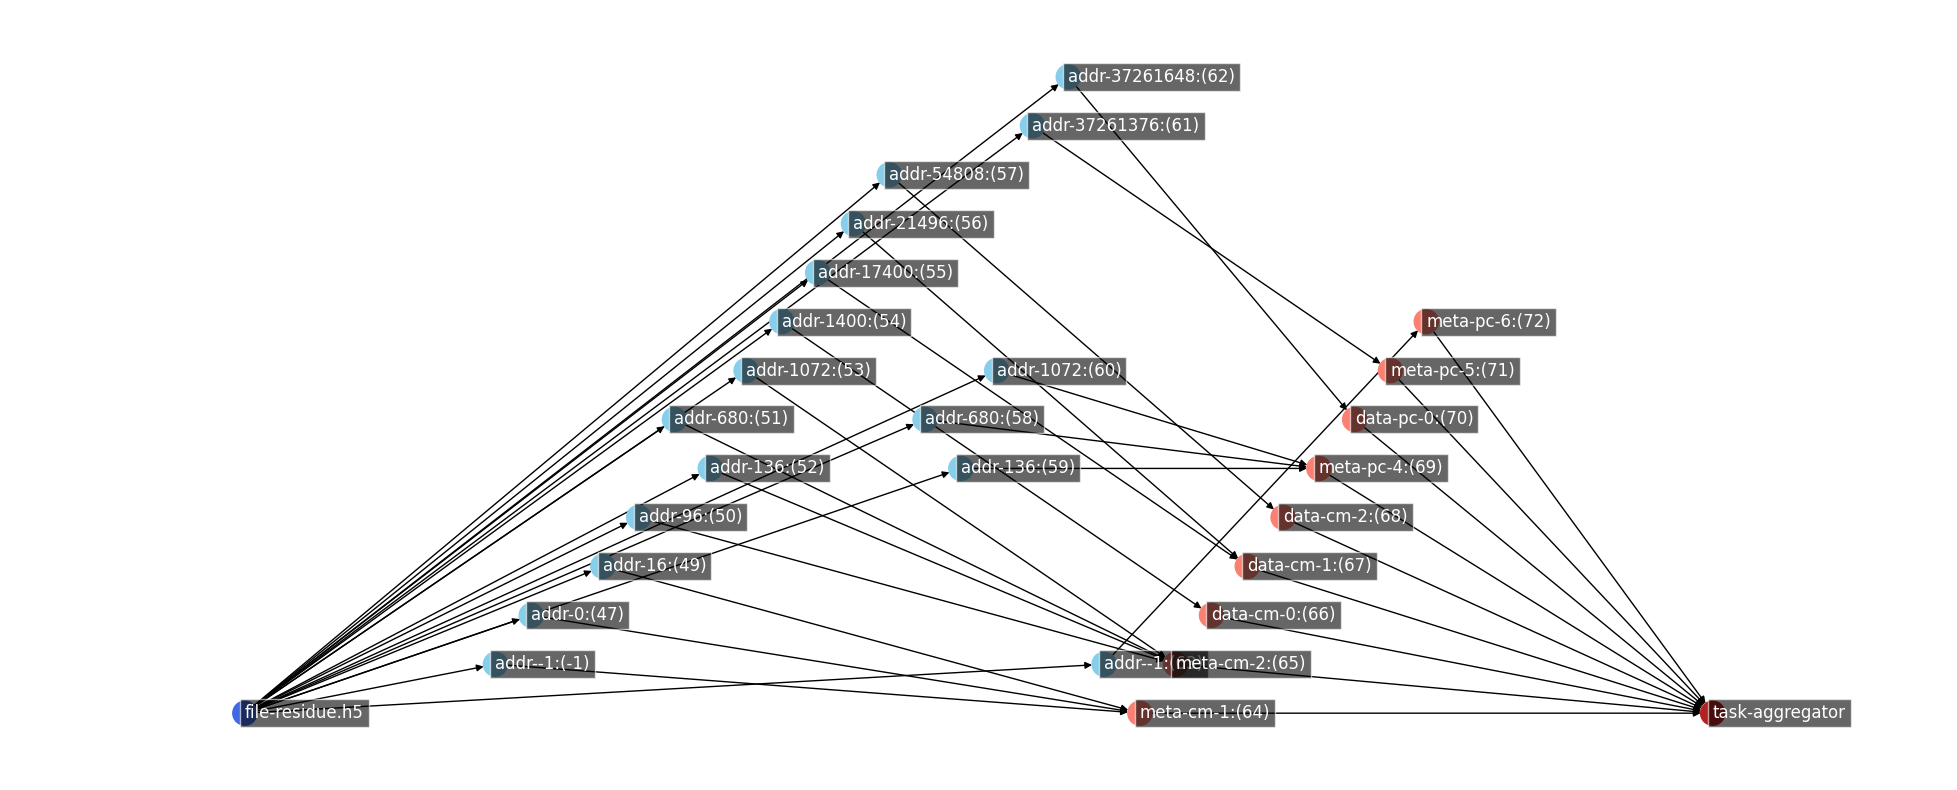

In [5]:
fagg_read='../save_outputs/vol-vfd/prov-vfd-agg-read-merged.csv'

df_agg_read_merged = read_data(fagg_read)
print(df_agg_read_merged.columns)
# print(df_agg_read_merged[df_agg_read_merged.operation_vol == 'open' ])

df_agg_read = pd.concat([df_agg_read_merged.head(nshow*2),df_agg_read_merged.tail(nshow)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr_vfd'
prev_node = get_min_max_loc(G_SIM)['max']
x_pos = list(prev_node.values())[0][0] #+ padding
# x_time = int(list(prev_node.keys())[0].split(':')[-1].replace('(','').replace(')',''))
print(f"prev_node = {prev_node}")
print(f"x_pos = {x_pos}")
print(f"x_time = {x_time}")

# convert time to rank
vfd_time = stats.rankdata(df_agg_read['time(us)_vfd'],method='dense')
vfd_time = [x+x_pos+padding for x in vfd_time]
# vfd_time = [x*step for x in vfd_time]
max_left = max(vfd_time)
vol_time = stats.rankdata(df_agg_read['time(us)_vol'],method='dense') #df_sim_merged['time(us)_vol'].min()
vol_time = [x + (max_left) for x in vol_time]
min_right = min(vol_time)
print(f"max_left = {max_left} min_right = {min_right}")
# df_agg_read['time(us)_vol'] += (max_left + x_pos)

G_AGG_R = nx.DiGraph()


add_nodes_edges(G_AGG_R, ['residue.h5'], list(df_agg_read['logical_addr_vfd']), 
                    list(df_agg_read['operation_vol']), 
                    list(df_agg_read['io_idx_vfd']),
                    [[0],vfd_time], 
                    acc_s=list(df_agg_read['access_size_vfd']),
                    x_pos=x_pos, tags=['file','agg_r-addr'])
# x_pos+=1
try:
    x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0]+ 1
except:
    print(nx.get_node_attributes(G_AGG_R,'pos').values())

add_nodes_edges(G_AGG_R, list(df_agg_read['logical_addr_vfd']), list(df_agg_read['data_label_vol']), 
                    list(df_agg_read['operation_vol']), 
                    list(df_agg_read['io_idx_vol']),
                    [vfd_time,vol_time], 
                    acc_s=list(df_agg_read['access_size_vfd']),
                    x_pos=x_pos, tags=['agg_r-addr','agg_r-vol'])

# x_pos+=1
x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0] + 1
x_time = max(vol_time) +1
add_nodes_edges(G_AGG_R, list(df_agg_read['data_label_vol']), ['aggregator'], 
                    list(df_agg_read['operation_vol']), 
                    list(df_agg_read['io_idx_vol']),
                    [vol_time, [0]], 
                    acc_s=list(df_agg_read['access_size_vol']),
                    x_pos=x_pos, tags=['agg_r-vol','task'])

# print(nx.get_edge_attributes(G_AGG_R,'operation'))
# print(nx.get_node_attributes(G_AGG_R,'pos'))
print(get_min_max_loc(G_AGG_R))

draw_graph(G_AGG_R,COLOR_MAP, rm_tags=['agg_r'])

In [6]:
F1 = nx.compose(G_SIM,G_AGG_R)
# draw_graph(F1,COLOR_MAP,rm_tags=['sim','agg_r'])


Index(['data_label_vol', 'object_idx_vol', 'dset_name', 'access_size_vol',
       'logical_addr_vol', 'op_type_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'io_idx_vol', 'logical_addr_map', 'data_label_vfd', 'object_idx_vfd',
       'access_size_vfd', 'logical_addr_vfd', 'next_addr', 'op_type_vfd',
       'file_name', 'time(us)_vfd', 'operation_vfd', 'io_idx_vfd'],
      dtype='object')
prev node : {'task-aggregator': (80, 0)}
{'min': {'task-aggregator': (80, 0)}, 'max': {'file-aggregate.h5': (113, 1)}}


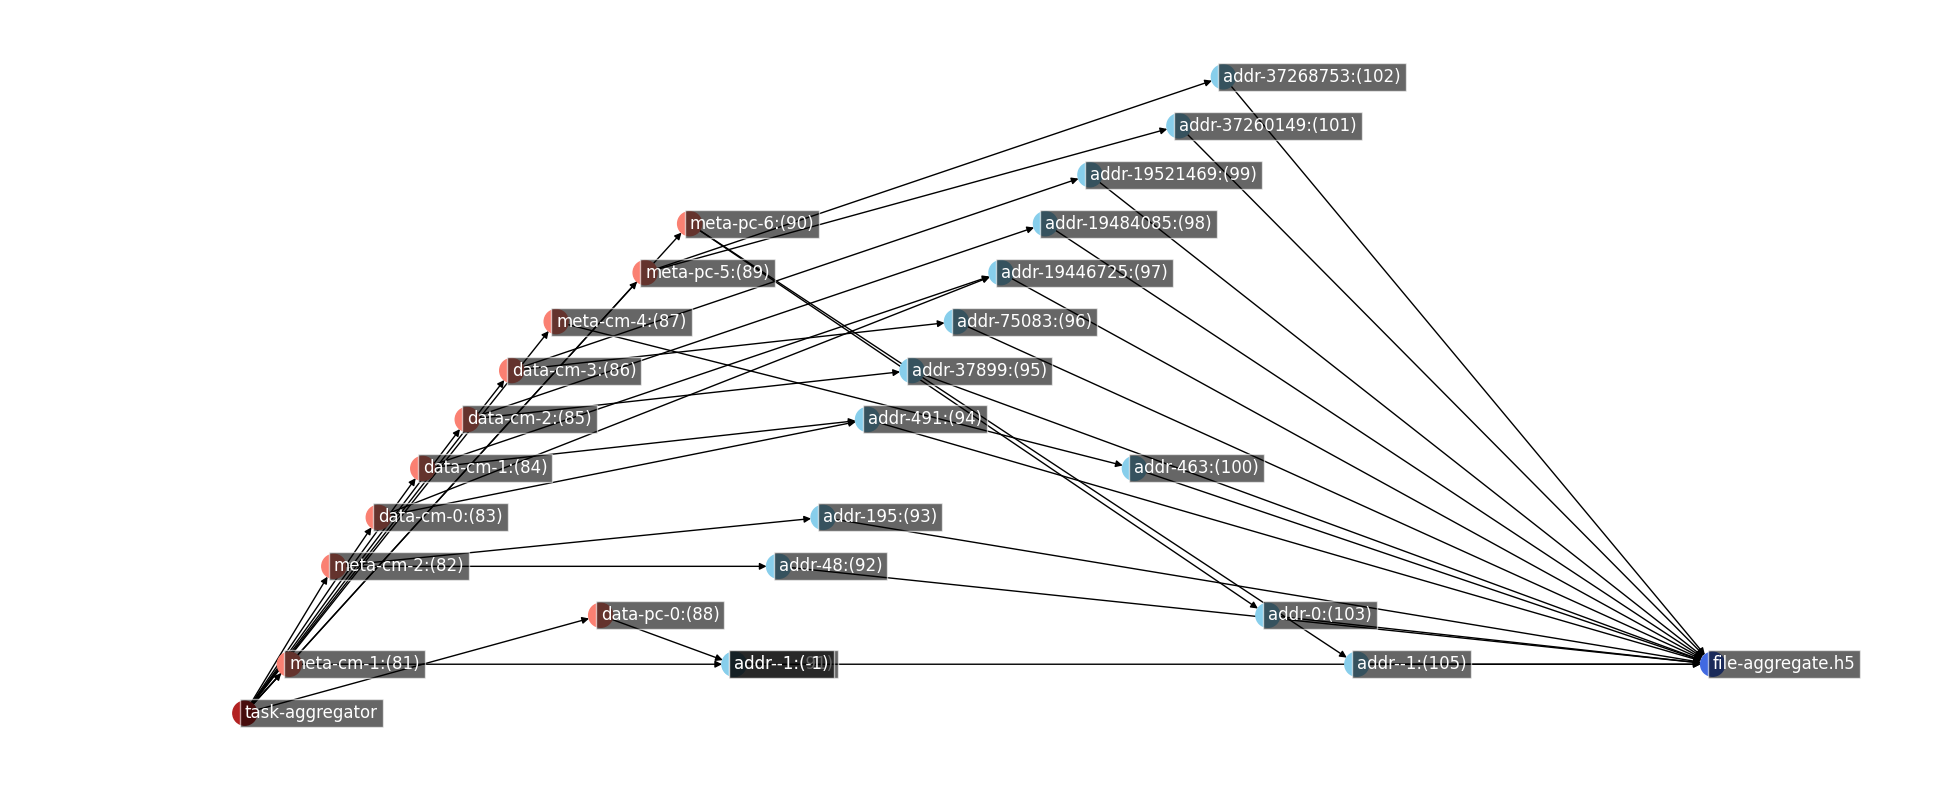

In [7]:
fagg_write='../save_outputs/vol-vfd/prov-vfd-agg-write-merged.csv'

df_agg_write_merged = read_data(fagg_write)

print(df_agg_write_merged.columns)

df_agg_write = pd.concat([df_agg_write_merged.head(nshow*2),df_agg_write_merged.tail(nshow)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr'
# x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0] #+ padding*4
prev_node = get_min_max_loc(G_AGG_R)['max']
x_pos = list(prev_node.values())[0][0] #+ padding
# x_time = int(list(prev_node.keys())[0].split(':')[-1].replace('(','').replace(')',''))
print(f"prev node : {prev_node}")

# convert time to rank
vol_time = stats.rankdata(df_agg_write['time(us)_vol'],method='dense') #df_sim_merged['time(us)_vol'].min()
vol_time = [x+x_pos for x in vol_time]
# vol_time = [x*step for x in vol_time]
max_left = max(vol_time)
vfd_time = stats.rankdata(df_agg_write['time(us)_vfd'],method='dense')
vfd_time = [x + (max_left) for x in vfd_time]
# vfd_time = [x*step for x in vfd_time]

G_AGG_W = nx.DiGraph()

add_nodes_edges(G_AGG_W, ['aggregator'], list(df_agg_write['data_label_vol']), 
                    list(df_agg_write['operation_vol']), 
                    list(df_agg_write['io_idx_vol']),
                    [[0], vol_time], 
                    acc_s=list(df_agg_write['access_size_vol']),
                    x_pos=x_pos, tags=['task','agg_w-vol'])
# x_pos+=1
x_pos = max(nx.get_node_attributes(G_AGG_W,'pos').values())[0] + 1
add_nodes_edges(G_AGG_W, list(df_agg_write['data_label_vol']), list(df_agg_write['logical_addr_vfd']), 
                    list(df_agg_write['operation_vol']), 
                    list(df_agg_write['io_idx_vfd']),
                    [vol_time,vfd_time], 
                    acc_s=list(df_agg_write['access_size_vfd']),
                    x_pos=x_pos, tags=['agg_w-vol','agg_w-addr'])
# x_pos+=1
x_pos = max(nx.get_node_attributes(G_AGG_W,'pos').values())[0] + 1
x_time = max(vol_time) +1
add_nodes_edges(G_AGG_W, list(df_agg_write['logical_addr_vfd']), ['aggregate.h5'], 
                    list(df_agg_write['operation_vol']), 
                    list(df_agg_write['io_idx_vfd']),
                    [vfd_time, [0]], 
                    acc_s=list(df_agg_write['access_size_vfd']),
                    x_pos=x_pos, tags=['agg_w-addr','file'])

print(get_min_max_loc(G_AGG_W))

# for e in G_AGG_W.edges:
#     print(e)

draw_graph(G_AGG_W,COLOR_MAP,rm_tags=['agg_w'])

In [8]:
F2 = nx.compose(F1, G_AGG_W)
# # print(nx.get_node_attributes(F2,'pos'))
# draw_graph(F2,COLOR_MAP,rm_tags=['sim','agg_r','agg_w'])


In [9]:
# Sankey related codes
EDGE_COLOR_MAP = {"create": "rgba(128, 128, 128, 0.7)", # grey
            "get": "rgba(128, 128, 128, 0.7)", #grey
            "open": "rgba(128, 128, 128, 0.7)", # grey
            "close": "rgba(128, 128, 128, 0.7)", # grey
            "none": "rgba(128, 128, 128, 0.7)", # grey
            "read": "rgba(221, 160, 221,0.7)", # light megenta
            "write": "rgba(147, 112, 219, 0.7)", # light purple
            }

def get_xy_position(G):
    pos_dict = nx.get_node_attributes(G,'pos')

    x_dict = {}
    x_pos = []
    y_dict = {}
    for n, pos in pos_dict.items():
        x_dict[n] = pos[0]
        y_dict[n] = pos[1]

    # print(x_dict)
    # print(y_pos)

    xf= 1.0/max(x_dict.values())
    x_pos = {k: v*xf for k, v in x_dict.items() }

    
    yf=1.0/max(y_dict.values())
    y_pos = {k: v*yf for k, v in y_dict.items() }

    # print(x_pos)
    # print(y_pos)
    
    return x_pos, y_pos

def get_links_for_sankey(G, node_dict_ref,edge_attr=['access_cnt','access_size','operation'],rm_tags=[]):

    link_dict_for_sankey = dict(
        source = [],
        target = [],
        value = [],
        label = [],
        color = [],
        customdata = [],
    )

    acc_cnt = nx.get_edge_attributes(G,edge_attr[0])
    attr_size = nx.get_edge_attributes(G,edge_attr[1])
    attr_op = nx.get_edge_attributes(G,edge_attr[2])
    
    # print(attr_dict)
    for u, v, attr in G.edges(data=True):
        # print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)
        link_dict_for_sankey['color'].append(EDGE_COLOR_MAP[attr_op[(u,v)]])
        # link_dict_for_sankey['value'].append(attr['weight])
        
        cnt = acc_cnt[(u,v)]
        size = attr_size[(u,v)]
        if size == 0:
            size = 1
        link_dict_for_sankey['value'].append(size)
        _str = f"Access Volume : {humansize(size)} <br />Average Count : {cnt} <br />Average Access Size : {humansize(size/cnt)} <br />"

        link_dict_for_sankey['label'].append(_str)
        link_dict_for_sankey['customdata'].append(cnt)
        # link_dict_for_sankey['acc_cnt'].append(cnt)
        
    return link_dict_for_sankey

def selected_graph(node_name, G):
    # this is not used
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

def get_nodes_for_sankey(G, rm_tags=[], thick=20, groups=[[0,0]]):
    node_dict_for_sankey = dict(
        label = [],
        color = [],
        x = [],
        y = [],
        # groups = groups,
        customdata = [],
        thickness = 20, #default=20
        pad = 10,
    )
    # 'line' : {'width':[]}, 

    node_dict_ref = {}
    col_idx = 0

    x_pos, y_pos = get_xy_position(G)
    pos_dict = nx.get_node_attributes(G,'pos')


    acc_size = nx.get_edge_attributes(G,'access_size')
    
    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        # node_type = 'file' if node_name[-4:] == 'residue_100.h5' else 'task'
        # print(f"{idx}, ({node_name}, {attr})")
        node_type = attr['name']
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        #sankey
        node_dict_for_sankey['label'].append(rm_name_tags(node_name,rm_tags))
        node_dict_for_sankey['color'].append(COLOR_MAP[rm_name_tags(node_type,rm_tags)])
        node_dict_for_sankey['x'].append(x_pos[node_name])
        node_dict_for_sankey['y'].append(y_pos[node_name])
        node_dict_for_sankey['customdata'].append(node_name.split('-')[0])
        # x = pos_dict[node_name][0]
        # y = pos_dict[node_name][1]
        # node_dict_for_sankey['groups'].append(0)

        
    return node_dict_for_sankey, node_dict_ref

In [10]:
sim_nodes, sim_nodes_dict = get_nodes_for_sankey(G_SIM, rm_tags=['sim'])

# print(node_ref2)
sim_links = get_links_for_sankey(G_SIM, sim_nodes_dict)

sim_sankey = go.Sankey(
            node = sim_nodes,
            link = sim_links, 
            orientation='h',
            domain=dict(
              row=0,
              column=0,),
            arrangement = "freeform",
            )

layout =  go.Layout(
    title = "Basic Sankey Diagram",
    bargap = 1,
    barmode = 'stack',
    font = dict(
      size = 10
    )
)
fig = go.Figure(sim_sankey)
fig.show()
fig.write_html(f"{path}/sankey-sampled-sim_w-vol-vfd-.html")

In [11]:
# agg_r_nodes, agg_r_nodes_dict = get_nodes_for_sankey(G_AGG_R,rm_tags=['agg_r'])

# # print(node_ref2)

# agg_r_links = get_links_for_sankey(G_AGG_R, agg_r_nodes_dict)
# fig = go.Figure(go.Sankey(
#             node = agg_r_nodes,
#             link = agg_r_links, orientation='h'))
# fig.show()
# fig.write_html(f"{path}/sankey-agg_r-vol-vfd.html")

In [12]:
AGG = nx.compose(G_AGG_R, G_AGG_W)
print(AGG)
print(get_min_max_loc(AGG))

min = 39
pos = nx.get_node_attributes(AGG,'pos')
AGG_SHIFT = AGG

for n in AGG.nodes:
  _x = pos[n][0] - min
  _y = pos[n][1]
  AGG_SHIFT.add_node(n,pos=(_x,_y))


# draw_graph(AGG,COLOR_MAP,rm_tags=['agg_r','agg_w'])

agg_nodes, agg_nodes_dict = get_nodes_for_sankey(AGG_SHIFT,rm_tags=['agg_r','agg_w'])

agg_links = get_links_for_sankey(AGG_SHIFT, agg_nodes_dict)

agg_sankey = go.Sankey(
            node = agg_nodes,
            link = agg_links, 
            orientation='h',
            # domain=dict(
            #   row=1,
            #   column=0,),
            arrangement = "freeform",
            )

layout =  go.Layout(
    title = "Basic Sankey Diagram",
    bargap = 1,
    barmode = 'stack',
    font = dict(
      size = 10
    )
)

fig = go.Figure(data=agg_sankey, layout=layout)
fig.show()
fig.write_html(f"{path}/sankey-sampled-agg-vol-vfd.html")

DiGraph with 54 nodes and 84 edges
{'min': {'file-residue.h5': (39, 0)}, 'max': {'file-aggregate.h5': (113, 1)}}


In [13]:
# data = [sim_sankey, agg_sankey] #
# layout =  go.Layout(
#     title = "Basic Sankey Diagram",
#     bargap = 1,
#     barmode = 'stack',
#     grid = dict(
#       rows = 2,
#       columns = 1
#     ),
#     margin = dict(
#       l=10,
#       r=10,
#     ),
# )

# fig = go.Figure(data=data, layout=layout)

# fig.show()
# fig.write_html(f"{path}/sankey-sampled-sim-agg-subplot.html")

In [14]:
f2_nodes, f2_nodes_dict = get_nodes_for_sankey(F2,rm_tags=['sim','agg_r','agg_w'])
# print(node_ref2)
f2_links = get_links_for_sankey(F2, f2_nodes_dict)

f2_sankey = go.Sankey(
            node = f2_nodes,
            link = f2_links, 
            orientation='h',
            arrangement = "freeform",
    )

layout =  go.Layout(
    title = "Basic Sankey Diagram",
    margin = dict(
      l=10,
      r=10,
    ),
    boxgap = 0.2,
    activeselection = dict(
      fillcolor = 'green',
      opacity = 0.8
    ),
    
    # clickmode = "event+select",
    activeshape = dict(
      fillcolor = 'green',
      opacity = 0.8
    ),
    autosize = True,
    
)


fig = go.Figure(data=f2_sankey, )
fig.show()
fig.write_html(f"{path}/sankey-sampled-sim_w_agg_r_w-vol-vfd.html")

## TODO: Convert to group below
1. create node maps, detailed_node : grouped_node
2. replace nodes
3. replace edges